In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

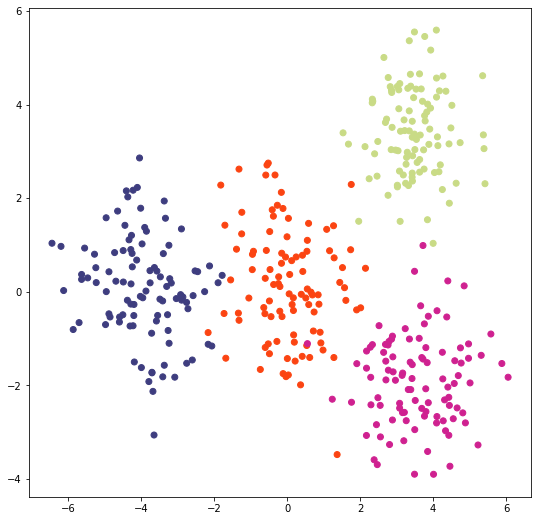

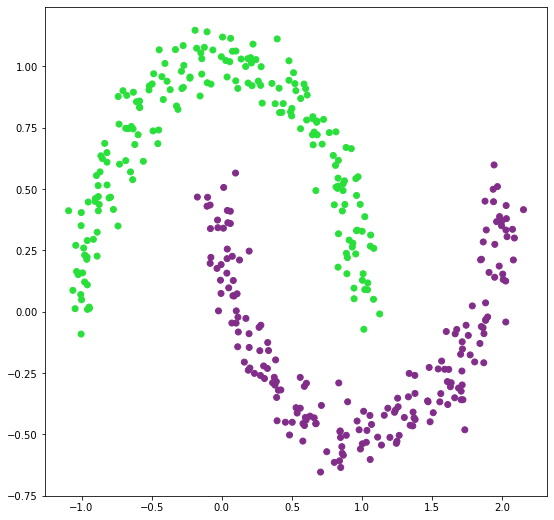

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Mетод K средних

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

In [162]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.

        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).

        """
        n = X.shape[0]
        if self.init == "random":
            x_min = X.min(axis=0)
            x_max = X.max(axis=0)
            centroids = np.random.uniform(x_min, x_max, size=(self.n_clusters, X_1.shape[1]))

        elif self.init == "sample":
            centroids = random.sample(list(X), k=self.n_clusters)
            centroids = np.array(centroids)

        elif self.init == "k-means++":
            centroids = random.sample(list(X), k=1)
            centroids = np.array(centroids)

            while centroids.shape[0] < self.n_clusters:
                sh = centroids.shape[0]
                distances = np.zeros(shape=(sh, n))
                for cluster in range(sh):
                    distances[cluster] = np.linalg.norm(X - centroids[cluster], axis=1) ** 2

                min_distances = np.amin(distances, axis=0)
                probability = min_distances / np.sum(min_distances)

                idx = np.random.choice(range(X.shape[0]), p=probability)
                centroid = X[idx]
                centroids = np.vstack((centroids, centroid))

        for i in range(self.max_iter):
            
            distances = np.zeros(shape=(self.n_clusters, n))
            for cluster in range(self.n_clusters):
                distances[cluster] = np.linalg.norm(X - centroids[cluster], axis=1)

            cur_clusters = np.argmin(distances, axis=0)

            for cluster in range(self.n_clusters):
                x_cluster = X[cur_clusters == cluster]
                if x_cluster.shape[0]:
                    centroids[cluster] = np.sum(x_cluster, axis=0) / x_cluster.shape[0]
                else:
                    centroids[cluster] = random.sample(list(X), k=1)[0]

        self.centroids = centroids
    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        n = X.shape[0]
        distances = np.zeros(shape=(self.n_clusters, n))
        for cluster in range(self.n_clusters):
            distances[cluster] = np.linalg.norm(X - self.centroids[cluster], axis=1)

        labels = np.argmin(distances, axis=0)
        
        return labels

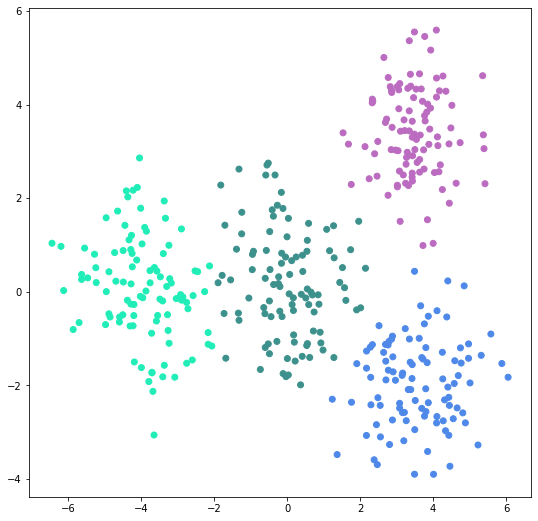

In [163]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

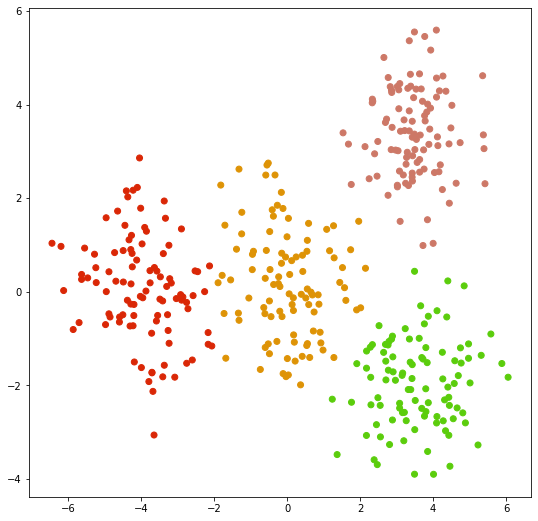

In [164]:
kmeans = KMeans(n_clusters=4, init = "sample")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

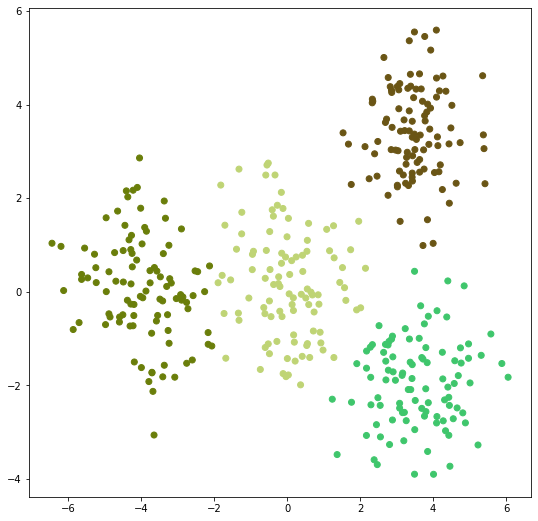

In [165]:
kmeans = KMeans(n_clusters=4, init = "k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

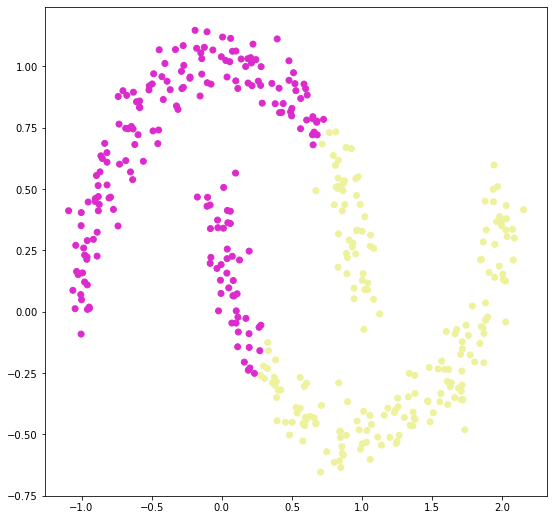

In [168]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

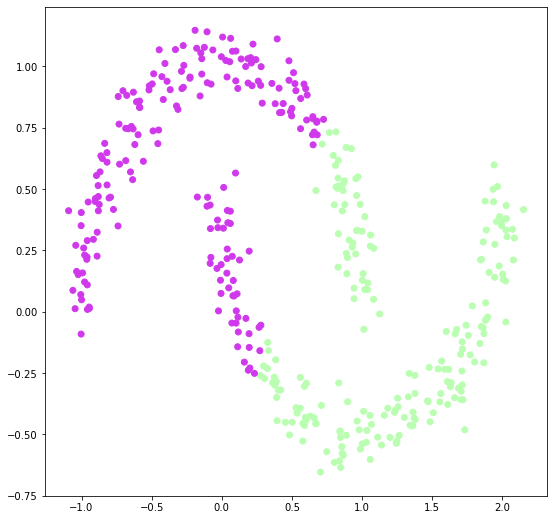

In [171]:
kmeans = KMeans(n_clusters=2, init = "sample")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

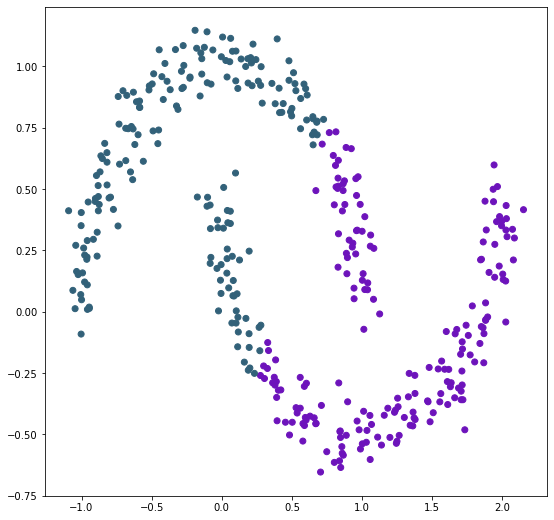

In [170]:
kmeans = KMeans(n_clusters=2, init = "k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)